In [1]:
import pandas as pd

df = pd.read_csv("phase7_anomaly_output.csv")

df["timestamp"] = pd.to_datetime(df["timestamp"])

print("Rows:", len(df))
print("Devices:", df["device_id"].unique())


Rows: 10686
Devices: ['EV_RICK_01' 'EV_SCOOT_01' 'EV_TAXI_01' 'NASA_B0005' 'NASA_B0043'
 'NASA_B0045' 'NASA_B0049' 'NASA_B0054']


Extract Latest State Per Device

In [2]:
latest_status = (
    df.sort_values("timestamp")
      .groupby("device_id")
      .tail(1)
      .reset_index(drop=True)
)

latest_status.head()


,timestamp,device_id,predicted_soh,predicted_rul_ratio,predicted_rul_cycles,soh_smooth,rul_smooth,soh_change,soh_anomaly,rul_change,rul_anomaly,low_soh_flag,low_rul_flag,risk_score,risk_level
0,1970-01-01 00:29:31.387037925,EV_SCOOT_01,0.954129,0.770075,153.244977,0.954129,153.244977,0.0,False,0.000000,False,False,False,0,Low
1,1970-01-01 00:29:31.387037925,EV_RICK_01,0.953608,0.769362,153.102973,0.953608,153.102973,0.0,False,0.000000,False,False,False,0,Low
2,1970-01-01 00:29:31.387037925,EV_TAXI_01,0.955363,0.770529,153.335360,0.955363,153.335360,0.0,False,0.000000,False,False,False,0,Low
3,1970-01-01 00:29:31.387037925,NASA_B0049,0.955363,0.826417,49.585047,0.955363,49.698860,0.0,False,-0.055839,False,False,False,0,Low
4,1970-01-01 00:29:31.387037925,NASA_B0043,0.955363,0.824071,225.795500,0.955363,224.893509,0.0,False,-0.080437,False,False,False,0,Low


Decision Engine

In [7]:
def reuse_decision(row):

    soh = row["soh_smooth"]
    rul = row["rul_smooth"]
    risk = row["risk_level"]

    # Highest priority
    if risk == "High":
        return "Immediate Inspection"

    # Very healthy
    if soh >= 0.90 and rul >= 60:
        return "Continue EV Operation"

    # Slight degradation
    if 0.85 <= soh < 0.90 or 40 <= rul < 60:
        return "Monitor Closely"

    # Moderate degradation
    if 0.75 <= soh < 0.85 or 20 <= rul < 40:
        return "Second Life Candidate"

    # End-of-life
    if soh < 0.75 or rul < 20:
        return "Recycle / End-of-Life"

    return "Monitor Closely"


In [8]:
latest_status["reuse_decision"] = latest_status.apply(reuse_decision, axis=1)

print(latest_status[[
    "device_id",
    "soh_smooth",
    "rul_smooth",
    "risk_level",
    "reuse_decision"
]])


     device_id  soh_smooth  rul_smooth risk_level         reuse_decision
0  EV_SCOOT_01    0.954129  153.244977        Low  Continue EV Operation
1   EV_RICK_01    0.953608  153.102973        Low  Continue EV Operation
2   EV_TAXI_01    0.955363  153.335360        Low  Continue EV Operation
3   NASA_B0049    0.955363   49.698860        Low        Monitor Closely
4   NASA_B0043    0.955363  224.893509        Low  Continue EV Operation
5   NASA_B0005    0.955363  476.466063        Low  Continue EV Operation
6   NASA_B0045    0.955363  163.559043        Low  Continue EV Operation
7   NASA_B0054    0.955363  199.018785        Low  Continue EV Operation


Fleet Decision Summary

In [9]:
print("Reuse Decision Summary:")
print(latest_status["reuse_decision"].value_counts())


Reuse Decision Summary:
reuse_decision
Continue EV Operation    7
Monitor Closely          1
Name: count, dtype: int64


Visualisation: Decision Distribution

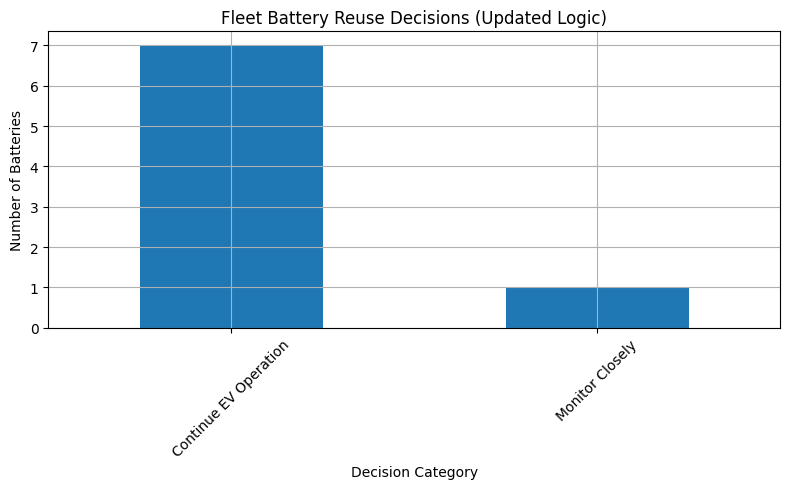

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

latest_status["reuse_decision"].value_counts().plot(kind="bar")

plt.title("Fleet Battery Reuse Decisions (Updated Logic)")
plt.xlabel("Decision Category")
plt.ylabel("Number of Batteries")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


Save Phase 8 Output

In [11]:
latest_status.to_csv("phase8_reuse_decisions.csv", index=False)

print("Phase 8 decision file saved.")


Phase 8 decision file saved.
